In [1]:
from google.colab import files

uploaded = files.upload()

Saving graphcast_heat_results.pkl to graphcast_heat_results.pkl
Saving fourcast_heat_results.pkl to fourcast_heat_results.pkl
Saving case_metadata.csv to case_metadata.csv


In [3]:
import pandas as pd
import numpy as np
fourcast_results = pd.read_pickle('fourcast_heat_results.pkl')
graphcast_results = pd.read_pickle('graphcast_heat_results.pkl')
case_metadata = pd.read_csv('case_metadata.csv')

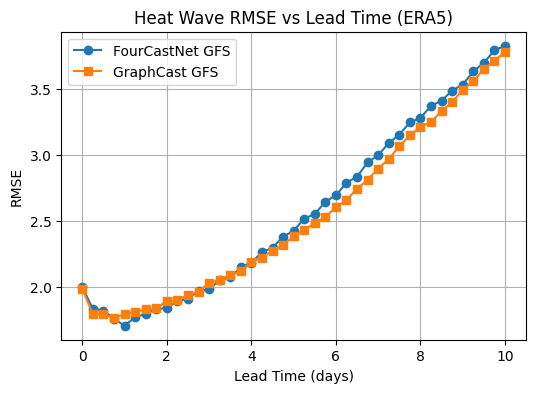

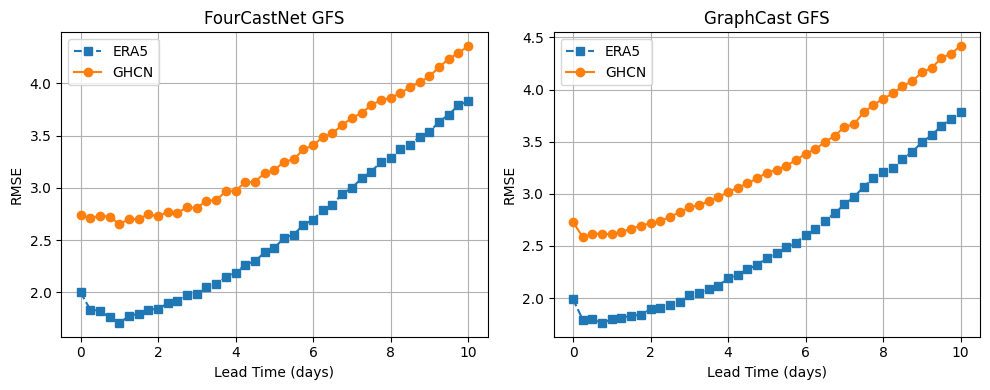

In [12]:
import matplotlib.pyplot as plt

def get_mean_by_lead_time(df, metric='RootMeanSquaredError', target_source='ERA5'):
    subset = df[(df['metric'] == metric) & (df['target_source'] == target_source)].copy()
    subset['lead_days'] = pd.to_timedelta(subset['lead_time']).dt.total_seconds() / 86400
    return subset.groupby('lead_days')['value'].mean()

# Plot 1: FourCast vs GraphCast
plt.figure(figsize=(6, 4))
fourcast_rmse = get_mean_by_lead_time(fourcast_results)
graphcast_rmse = get_mean_by_lead_time(graphcast_results)
plt.plot(fourcast_rmse.index, fourcast_rmse.values, marker='o', label='FourCastNet GFS')
plt.plot(graphcast_rmse.index, graphcast_rmse.values, marker='s', label='GraphCast GFS')
plt.xlabel('Lead Time (days)')
plt.ylabel('RMSE')
plt.title('Heat Wave RMSE vs Lead Time (ERA5)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: ERA5 vs GHCN comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (name, df) in zip(axes, [('FourCastNet GFS', fourcast_results), ('GraphCast GFS', graphcast_results)]):
    era5 = get_mean_by_lead_time(df, target_source='ERA5')
    ghcn = get_mean_by_lead_time(df, target_source='GHCN')
    ax.plot(era5.index, era5.values, marker='s', linestyle='--', label='ERA5')
    ax.plot(ghcn.index, ghcn.values, marker='o', linestyle='-', label='GHCN')
    ax.set_xlabel('Lead Time (days)')
    ax.set_ylabel('RMSE')
    ax.set_title(name)
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

In [61]:
case_metadata.head()

,case_id_number,title,event_type,lat_min,lat_max,lon_min,lon_max,start_date,end_date,lon_min_converted,lon_max_converted,year,month
0,1,2021 Pacific Northwest,heat_wave,33.25,68.00,215.25,256.00,2021-06-20 00:00:00,2021-07-03 00:00:00,-144.75,-104.00,2021,6
1,2,2022 Upper Midwest,heat_wave,19.50,48.25,252.00,276.75,2022-05-07 00:00:00,2022-05-17 00:00:00,-108.00,-83.25,2022,5
2,3,2022 California,heat_wave,23.75,44.50,235.75,266.25,2022-06-07 00:00:00,2022-06-15 00:00:00,-124.25,-93.75,2022,6
3,4,2022 Texas,heat_wave,20.50,43.25,254.75,275.50,2022-06-30 00:00:00,2022-07-18 00:00:00,-105.25,-84.50,2022,6
4,5,2023 Pacific Northwest,heat_wave,35.25,72.00,219.25,262.00,2023-05-10 00:00:00,2023-05-23 00:00:00,-140.75,-98.00,2023,5


In [14]:
!pip install cartopy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.1 MB/s eta 0:00:00


In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import seaborn as sns

In [35]:
case_metadata.groupby(
    pd.cut(case_metadata['lon_min_converted'], bins=[-180, -100, -30, 30, 100, 180])
).size()

/tmp/ipython-input-1992347741.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  case_metadata.groupby(


,0
lon_min_converted,
"(-180, -100]",15
"(-100, -30]",8
"(-30, 30]",20
"(30, 100]",8
"(100, 180]",9


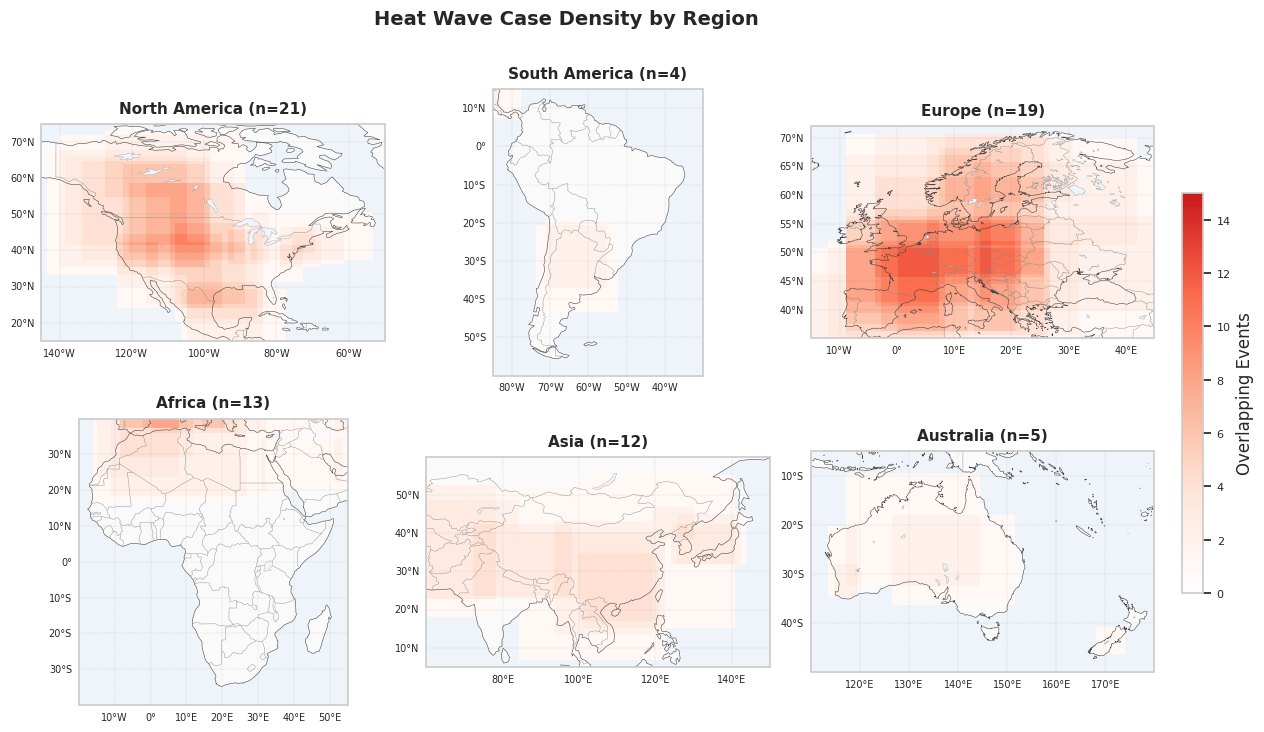

{'North America': 21, 'South America': 4, 'Europe': 19, 'Africa': 13, 'Asia': 12, 'Australia': 5}


In [34]:
REGIONS = {
    'North America': {
        'extent': [-145, -50, 15, 75],
        'lon_range': (-145, -50),
        'lat_range': (15, 75)
    },
    'South America': {
        'extent': [-85, -30, -60, 15],
        'lon_range': (-85, -30),
        'lat_range': (-60, 15)
    },
    'Europe': {
        'extent': [-15, 45, 35, 72],
        'lon_range': (-15, 45),
        'lat_range': (35, 72)
    },
    'Africa': {
        'extent': [-20, 55, -40, 40],
        'lon_range': (-20, 55),
        'lat_range': (-40, 40)
    },
    'Asia': {
        'extent': [60, 150, 5, 60],
        'lon_range': (60, 150),
        'lat_range': (5, 60)
    },
    'Australia': {
        'extent': [110, 180, -50, -5],
        'lon_range': (110, 180),
        'lat_range': (-50, -5)
    },
}

fig, axes = plt.subplots(2, 3, figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

cmap = mcolors.LinearSegmentedColormap.from_list('', ['#ffffff', '#fee5d9', '#fcae91', '#fb6a4a', '#cb181d'])

region_cases = {}
vmax_global = 15

for ax, (name, config) in zip(axes, REGIONS.items()):
    ax.add_feature(cfeature.OCEAN, facecolor='#eef4f9')
    ax.add_feature(cfeature.LAND, facecolor='#fafafa', edgecolor='none')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor='#444444')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.3, edgecolor='#888888')
    ax.add_feature(cfeature.LAKES, facecolor='#eef4f9', edgecolor='#888888', linewidth=0.2)

    ext = config['extent']
    ax.set_extent(ext, crs=ccrs.PlateCarree())

    lon_bins = np.linspace(ext[0], ext[1], 60)
    lat_bins = np.linspace(ext[2], ext[3], 60)
    density = np.zeros((len(lat_bins)-1, len(lon_bins)-1))

    case_ids = get_cases_in_region(case_metadata, config['lon_range'], config['lat_range'])
    region_cases[name] = case_ids
    region_data = case_metadata[case_metadata['case_id_number'].isin(case_ids)]

    for _, row in region_data.iterrows():
        lon_min, lon_max = row['lon_min_converted'], row['lon_max_converted']
        lat_min, lat_max = row['lat_min'], row['lat_max']

        lon_min, lon_max = max(lon_min, ext[0]), min(lon_max, ext[1])
        lat_min, lat_max = max(lat_min, ext[2]), min(lat_max, ext[3])

        lon_mask = (lon_bins[:-1] >= lon_min) & (lon_bins[1:] <= lon_max)
        lat_mask = (lat_bins[:-1] >= lat_min) & (lat_bins[1:] <= lat_max)
        density[np.ix_(lat_mask, lon_mask)] += 1

    density_masked = np.ma.masked_where(density == 0, density)
    im = ax.pcolormesh(lon_bins, lat_bins, density_masked, cmap=cmap,
                       transform=ccrs.PlateCarree(), vmin=0, vmax=vmax_global)

    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {'size': 7}

    ax.set_title(f'{name} (n={len(case_ids)})', fontsize=11, fontweight='bold', pad=8)

fig.subplots_adjust(right=0.92, wspace=0.12, hspace=0.15)
cbar_ax = fig.add_axes([0.94, 0.25, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, label='Overlapping Events')
cbar.ax.tick_params(labelsize=8)

plt.suptitle('Heat Wave Case Density by Region', fontsize=14, fontweight='bold', y=0.98)
plt.show()

print({k: len(v) for k, v in region_cases.items()})

In [36]:
# Find case with highest error or largest coverage
fourcast_results.groupby('case_id_number')['value'].mean().sort_values(ascending=False).head(10)

,value
case_id_number,
76,5.800643
25,4.567169
72,3.830792
24,3.218094
29,3.217682
78,3.069221
22,3.007775
86,3.001731
17,2.971416


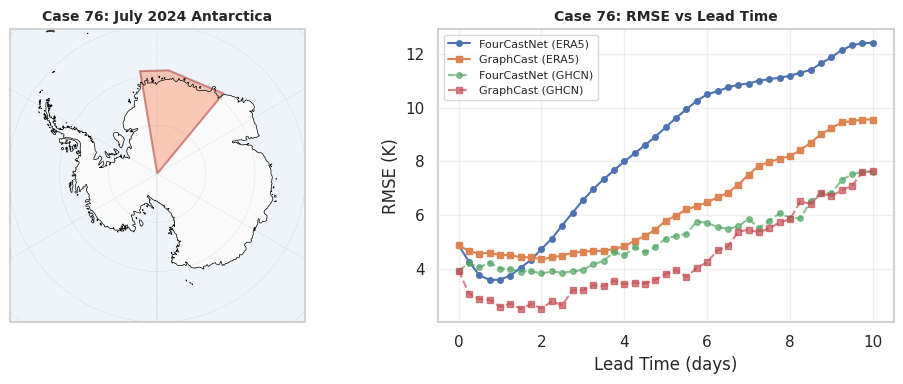

Title: July 2024 Antarctica
Date: 2024-07-01 00:00:00 to 2024-07-31 00:00:00


In [52]:
# Case 76 - July 2024 Antarctica
case_76 = case_metadata[case_metadata['case_id_number'] == 76]
case_76_fourcast = fourcast_results[fourcast_results['case_id_number'] == 76]
case_76_graphcast = graphcast_results[graphcast_results['case_id_number'] == 76]

fig = plt.figure(figsize=(10, 4))

# Plot 1: Map
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='#fafafa')
ax1.add_feature(cfeature.OCEAN, facecolor='#eef4f9')
ax1.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='--')

row = case_76.iloc[0]
ax1.fill([row['lon_min_converted'], row['lon_max_converted'], row['lon_max_converted'], row['lon_min_converted']],
         [row['lat_min'], row['lat_min'], row['lat_max'], row['lat_max']],
         color='coral', alpha=0.4, transform=ccrs.PlateCarree(), edgecolor='darkred', linewidth=1.5)
ax1.set_title(f"Case 76: {row['title']}", fontsize=10, fontweight='bold')

# Plot 2: RMSE with all 4 lines
ax2 = plt.subplot(1, 2, 2)

fc_rmse = case_76_fourcast[case_76_fourcast['metric'] == 'RootMeanSquaredError'].copy()
gc_rmse = case_76_graphcast[case_76_graphcast['metric'] == 'RootMeanSquaredError'].copy()

fc_rmse['lead_days'] = pd.to_timedelta(fc_rmse['lead_time']).dt.total_seconds() / 86400
gc_rmse['lead_days'] = pd.to_timedelta(gc_rmse['lead_time']).dt.total_seconds() / 86400

fc_era5 = fc_rmse[fc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
gc_era5 = gc_rmse[gc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
fc_ghcn = fc_rmse[fc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()
gc_ghcn = gc_rmse[gc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()

ax2.plot(fc_era5.index, fc_era5.values, marker='o', label='FourCastNet (ERA5)', markersize=4)
ax2.plot(gc_era5.index, gc_era5.values, marker='s', label='GraphCast (ERA5)', markersize=4)
ax2.plot(fc_ghcn.index, fc_ghcn.values, marker='o', linestyle='--', label='FourCastNet (GHCN)', markersize=4, alpha=0.7)
ax2.plot(gc_ghcn.index, gc_ghcn.values, marker='s', linestyle='--', label='GraphCast (GHCN)', markersize=4, alpha=0.7)

ax2.set_xlabel('Lead Time (days)')
ax2.set_ylabel('RMSE (K)')
ax2.set_title('Case 76: RMSE vs Lead Time', fontsize=10, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Title: {row['title']}")
print(f"Date: {row['start_date']} to {row['end_date']}")

Case 25 data availability:
FourCast: {'ERA5': 123, 'GHCN': 123}
GraphCast: {'ERA5': 123, 'GHCN': 123}


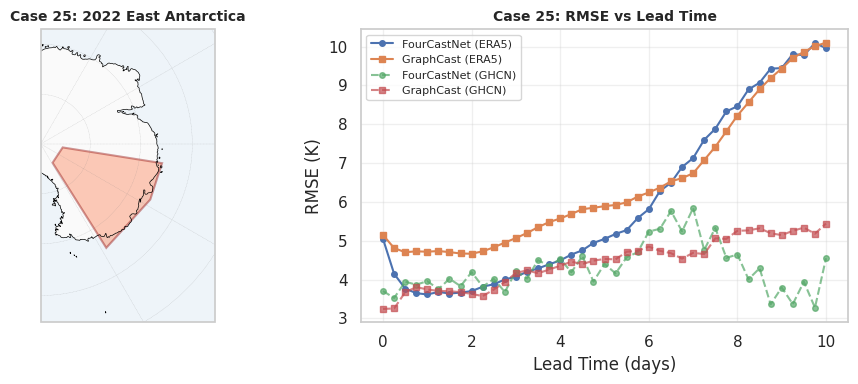

Title: 2022 East Antarctica
Date: 2022-03-12 00:00:00 to 2022-03-26 00:00:00


In [54]:
# Case 25 - 2022 East Antarctica
case_25 = case_metadata[case_metadata['case_id_number'] == 25]
case_25_fourcast = fourcast_results[fourcast_results['case_id_number'] == 25]
case_25_graphcast = graphcast_results[graphcast_results['case_id_number'] == 25]

print("Case 25 data availability:")
print("FourCast:", case_25_fourcast['target_source'].value_counts().to_dict())
print("GraphCast:", case_25_graphcast['target_source'].value_counts().to_dict())

fig = plt.figure(figsize=(10, 4))

# Plot 1: Map
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1.set_extent([50, 180, -90, -55], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='#fafafa')
ax1.add_feature(cfeature.OCEAN, facecolor='#eef4f9')
ax1.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='--')

row = case_25.iloc[0]
ax1.fill([row['lon_min_converted'], row['lon_max_converted'], row['lon_max_converted'], row['lon_min_converted']],
         [row['lat_min'], row['lat_min'], row['lat_max'], row['lat_max']],
         color='coral', alpha=0.4, transform=ccrs.PlateCarree(), edgecolor='darkred', linewidth=1.5)
ax1.set_title(f"Case 25: {row['title']}", fontsize=10, fontweight='bold')

# Plot 2: RMSE with all 4 lines
ax2 = plt.subplot(1, 2, 2)

fc_rmse = case_25_fourcast[case_25_fourcast['metric'] == 'RootMeanSquaredError'].copy()
gc_rmse = case_25_graphcast[case_25_graphcast['metric'] == 'RootMeanSquaredError'].copy()

fc_rmse['lead_days'] = pd.to_timedelta(fc_rmse['lead_time']).dt.total_seconds() / 86400
gc_rmse['lead_days'] = pd.to_timedelta(gc_rmse['lead_time']).dt.total_seconds() / 86400

fc_era5 = fc_rmse[fc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
gc_era5 = gc_rmse[gc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
fc_ghcn = fc_rmse[fc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()
gc_ghcn = gc_rmse[gc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()

ax2.plot(fc_era5.index, fc_era5.values, marker='o', label='FourCastNet (ERA5)', markersize=4)
ax2.plot(gc_era5.index, gc_era5.values, marker='s', label='GraphCast (ERA5)', markersize=4)
ax2.plot(fc_ghcn.index, fc_ghcn.values, marker='o', linestyle='--', label='FourCastNet (GHCN)', markersize=4, alpha=0.7)
ax2.plot(gc_ghcn.index, gc_ghcn.values, marker='s', linestyle='--', label='GraphCast (GHCN)', markersize=4, alpha=0.7)

ax2.set_xlabel('Lead Time (days)')
ax2.set_ylabel('RMSE (K)')
ax2.set_title('Case 25: RMSE vs Lead Time', fontsize=10, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Title: {row['title']}")
print(f"Date: {row['start_date']} to {row['end_date']}")

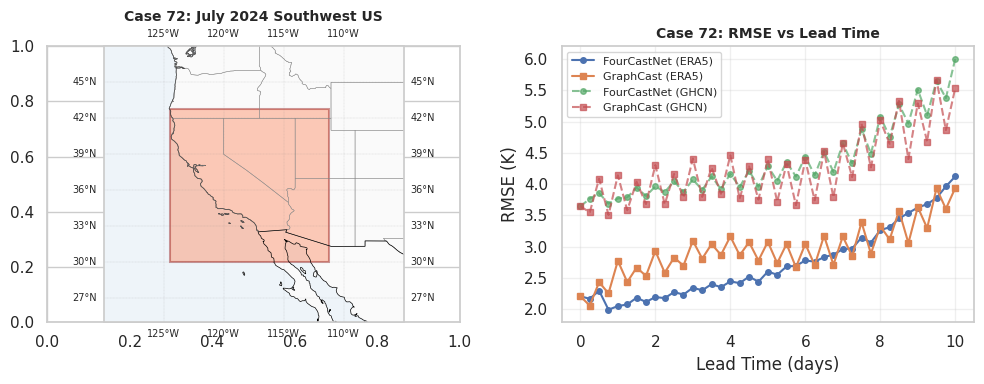

Title: July 2024 Southwest US
Date: 2024-07-04 00:00:00 to 2024-07-10 00:00:00
Location: Lat 30.0° to 42.75°, Lon -124.5° to -111.25°


In [42]:
case_72 = case_metadata[case_metadata['case_id_number'] == 72]
case_72_fourcast = fourcast_results[fourcast_results['case_id_number'] == 72]
case_72_graphcast = graphcast_results[graphcast_results['case_id_number'] == 72]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Map of the case
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-130, -105, 25, 48], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='#fafafa')
ax1.add_feature(cfeature.OCEAN, facecolor='#eef4f9')
ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='#888888')
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--',
              xlabel_style={'size': 7}, ylabel_style={'size': 7})

row = case_72.iloc[0]
ax1.fill([row['lon_min_converted'], row['lon_max_converted'], row['lon_max_converted'], row['lon_min_converted']],
         [row['lat_min'], row['lat_min'], row['lat_max'], row['lat_max']],
         color='coral', alpha=0.4, transform=ccrs.PlateCarree(), edgecolor='darkred', linewidth=1.5)
ax1.set_title(f"Case 72: {row['title']}", fontsize=10, fontweight='bold')

# Plot 2: RMSE by lead time
ax2 = plt.subplot(1, 2, 2)
fc_rmse = case_72_fourcast[case_72_fourcast['metric'] == 'RootMeanSquaredError'].copy()
gc_rmse = case_72_graphcast[case_72_graphcast['metric'] == 'RootMeanSquaredError'].copy()

fc_rmse['lead_days'] = pd.to_timedelta(fc_rmse['lead_time']).dt.total_seconds() / 86400
gc_rmse['lead_days'] = pd.to_timedelta(gc_rmse['lead_time']).dt.total_seconds() / 86400

fc_era5 = fc_rmse[fc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
gc_era5 = gc_rmse[gc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
fc_ghcn = fc_rmse[fc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()
gc_ghcn = gc_rmse[gc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()

ax2.plot(fc_era5.index, fc_era5.values, marker='o', label='FourCastNet (ERA5)', markersize=4)
ax2.plot(gc_era5.index, gc_era5.values, marker='s', label='GraphCast (ERA5)', markersize=4)
ax2.plot(fc_ghcn.index, fc_ghcn.values, marker='o', linestyle='--', label='FourCastNet (GHCN)', markersize=4, alpha=0.7)
ax2.plot(gc_ghcn.index, gc_ghcn.values, marker='s', linestyle='--', label='GraphCast (GHCN)', markersize=4, alpha=0.7)

ax2.set_xlabel('Lead Time (days)')
ax2.set_ylabel('RMSE (K)')
ax2.set_title('Case 72: RMSE vs Lead Time', fontsize=10, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Title: {row['title']}")
print(f"Date: {row['start_date']} to {row['end_date']}")
print(f"Location: Lat {row['lat_min']}° to {row['lat_max']}°, Lon {row['lon_min_converted']}° to {row['lon_max_converted']}°")

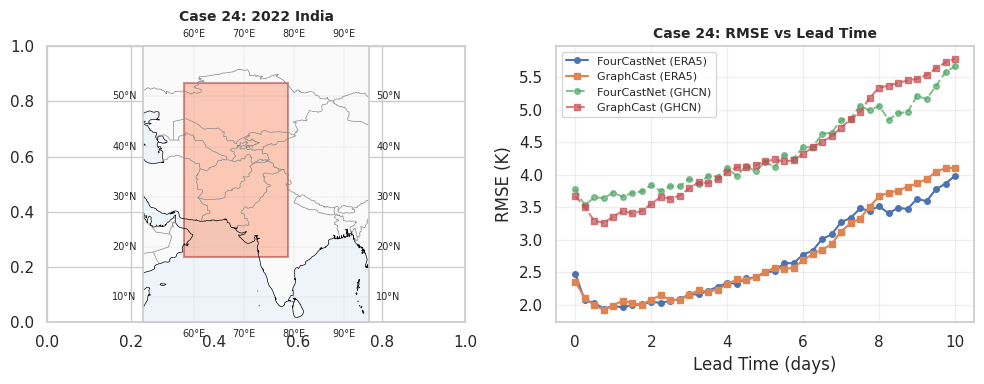

Title: 2022 India
Date: 2022-04-24 00:00:00 to 2022-05-04 00:00:00
Location: Lat 18.0° to 52.75°, Lon 58.0° to 78.75°


In [44]:
case_24 = case_metadata[case_metadata['case_id_number'] == 24]
case_24_fourcast = fourcast_results[fourcast_results['case_id_number'] == 24]
case_24_graphcast = graphcast_results[graphcast_results['case_id_number'] == 24]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Map of the case
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50, 95, 5, 60], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='#fafafa')
ax1.add_feature(cfeature.OCEAN, facecolor='#eef4f9')
ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='#888888')
ax1.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--',
              xlabel_style={'size': 7}, ylabel_style={'size': 7})

row = case_24.iloc[0]
ax1.fill([row['lon_min_converted'], row['lon_max_converted'], row['lon_max_converted'], row['lon_min_converted']],
         [row['lat_min'], row['lat_min'], row['lat_max'], row['lat_max']],
         color='coral', alpha=0.4, transform=ccrs.PlateCarree(), edgecolor='darkred', linewidth=1.5)
ax1.set_title(f"Case 24: {row['title']}", fontsize=10, fontweight='bold')

# Plot 2: RMSE by lead time
ax2 = plt.subplot(1, 2, 2)
fc_rmse = case_24_fourcast[case_24_fourcast['metric'] == 'RootMeanSquaredError'].copy()
gc_rmse = case_24_graphcast[case_24_graphcast['metric'] == 'RootMeanSquaredError'].copy()

fc_rmse['lead_days'] = pd.to_timedelta(fc_rmse['lead_time']).dt.total_seconds() / 86400
gc_rmse['lead_days'] = pd.to_timedelta(gc_rmse['lead_time']).dt.total_seconds() / 86400

fc_era5 = fc_rmse[fc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
gc_era5 = gc_rmse[gc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
fc_ghcn = fc_rmse[fc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()
gc_ghcn = gc_rmse[gc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()

ax2.plot(fc_era5.index, fc_era5.values, marker='o', label='FourCastNet (ERA5)', markersize=4)
ax2.plot(gc_era5.index, gc_era5.values, marker='s', label='GraphCast (ERA5)', markersize=4)
ax2.plot(fc_ghcn.index, fc_ghcn.values, marker='o', linestyle='--', label='FourCastNet (GHCN)', markersize=4, alpha=0.7)
ax2.plot(gc_ghcn.index, gc_ghcn.values, marker='s', linestyle='--', label='GraphCast (GHCN)', markersize=4, alpha=0.7)

ax2.set_xlabel('Lead Time (days)')
ax2.set_ylabel('RMSE (K)')
ax2.set_title('Case 24: RMSE vs Lead Time', fontsize=10, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Title: {row['title']}")
print(f"Date: {row['start_date']} to {row['end_date']}")
print(f"Location: Lat {row['lat_min']}° to {row['lat_max']}°, Lon {row['lon_min_converted']}° to {row['lon_max_converted']}°")

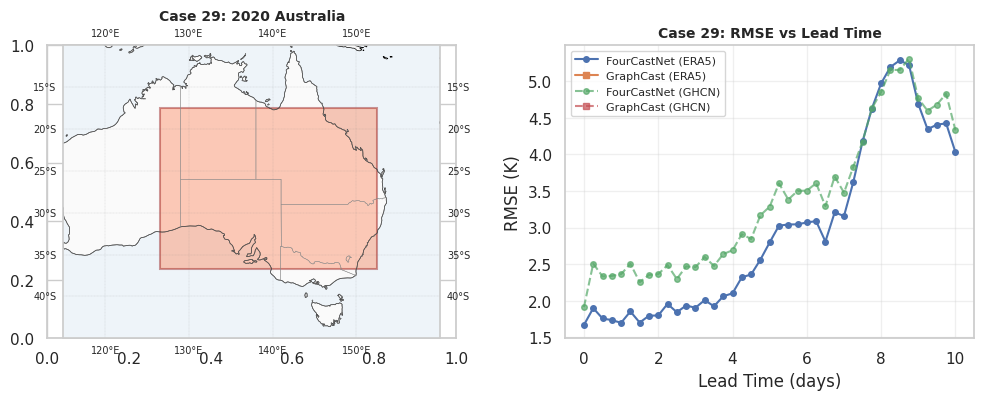

Title: 2020 Australia
Date: 2020-11-25 00:00:00 to 2020-12-01 00:00:00
Location: Lat -36.75° to -17.5°, Lon 126.5° to 152.5°


In [47]:
case_29 = case_metadata[case_metadata['case_id_number'] == 29]
case_29_fourcast = fourcast_results[fourcast_results['case_id_number'] == 29]
case_29_graphcast = graphcast_results[graphcast_results['case_id_number'] == 29]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Map of the case
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([115, 160, -45, -10], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='#fafafa')
ax1.add_feature(cfeature.OCEAN, facecolor='#eef4f9')
ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='#888888')
ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='#888888')
ax1.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--',
              xlabel_style={'size': 7}, ylabel_style={'size': 7})

row = case_29.iloc[0]
ax1.fill([row['lon_min_converted'], row['lon_max_converted'], row['lon_max_converted'], row['lon_min_converted']],
         [row['lat_min'], row['lat_min'], row['lat_max'], row['lat_max']],
         color='coral', alpha=0.4, transform=ccrs.PlateCarree(), edgecolor='darkred', linewidth=1.5)
ax1.set_title(f"Case 29: {row['title']}", fontsize=10, fontweight='bold')

# Plot 2: RMSE by lead time
ax2 = plt.subplot(1, 2, 2)
fc_rmse = case_29_fourcast[case_29_fourcast['metric'] == 'RootMeanSquaredError'].copy()
gc_rmse = case_29_graphcast[case_29_graphcast['metric'] == 'RootMeanSquaredError'].copy()

fc_rmse['lead_days'] = pd.to_timedelta(fc_rmse['lead_time']).dt.total_seconds() / 86400
gc_rmse['lead_days'] = pd.to_timedelta(gc_rmse['lead_time']).dt.total_seconds() / 86400

fc_era5 = fc_rmse[fc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
gc_era5 = gc_rmse[gc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
fc_ghcn = fc_rmse[fc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()
gc_ghcn = gc_rmse[gc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()

ax2.plot(fc_era5.index, fc_era5.values, marker='o', label='FourCastNet (ERA5)', markersize=4)
ax2.plot(gc_era5.index, gc_era5.values, marker='s', label='GraphCast (ERA5)', markersize=4)
ax2.plot(fc_ghcn.index, fc_ghcn.values, marker='o', linestyle='--', label='FourCastNet (GHCN)', markersize=4, alpha=0.7)
ax2.plot(gc_ghcn.index, gc_ghcn.values, marker='s', linestyle='--', label='GraphCast (GHCN)', markersize=4, alpha=0.7)

ax2.set_xlabel('Lead Time (days)')
ax2.set_ylabel('RMSE (K)')
ax2.set_title('Case 29: RMSE vs Lead Time', fontsize=10, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Title: {row['title']}")
print(f"Date: {row['start_date']} to {row['end_date']}")
print(f"Location: Lat {row['lat_min']}° to {row['lat_max']}°, Lon {row['lon_min_converted']}° to {row['lon_max_converted']}°")

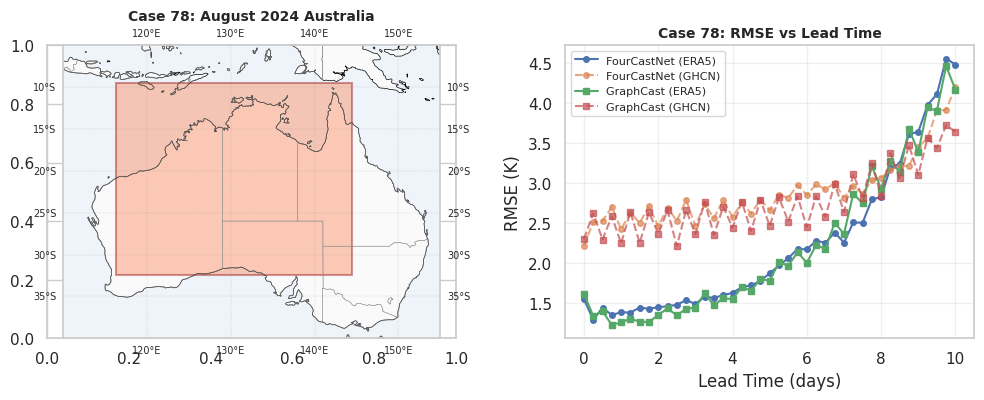

Title: August 2024 Australia
Date: 2024-08-22 00:00:00 to 2024-08-30 00:00:00
FourCast data: 246, GraphCast data: 246


In [50]:
case_78 = case_metadata[case_metadata['case_id_number'] == 78]
case_78_fourcast = fourcast_results[fourcast_results['case_id_number'] == 78]
case_78_graphcast = graphcast_results[graphcast_results['case_id_number'] == 78]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Map
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([110, 155, -40, -5], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='#fafafa')
ax1.add_feature(cfeature.OCEAN, facecolor='#eef4f9')
ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='#888888')
ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='#888888')
ax1.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--',
              xlabel_style={'size': 7}, ylabel_style={'size': 7})

row = case_78.iloc[0]
ax1.fill([row['lon_min_converted'], row['lon_max_converted'], row['lon_max_converted'], row['lon_min_converted']],
         [row['lat_min'], row['lat_min'], row['lat_max'], row['lat_max']],
         color='coral', alpha=0.4, transform=ccrs.PlateCarree(), edgecolor='darkred', linewidth=1.5)
ax1.set_title(f"Case 78: {row['title']}", fontsize=10, fontweight='bold')

# Plot 2: RMSE by lead time
ax2 = plt.subplot(1, 2, 2)

# FourCast
fc_rmse = case_78_fourcast[case_78_fourcast['metric'] == 'RootMeanSquaredError'].copy()
if len(fc_rmse) > 0:
    fc_rmse['lead_days'] = pd.to_timedelta(fc_rmse['lead_time']).dt.total_seconds() / 86400
    fc_era5 = fc_rmse[fc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
    fc_ghcn = fc_rmse[fc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()
    if len(fc_era5) > 0:
        ax2.plot(fc_era5.index, fc_era5.values, marker='o', label='FourCastNet (ERA5)', markersize=4)
    if len(fc_ghcn) > 0:
        ax2.plot(fc_ghcn.index, fc_ghcn.values, marker='o', linestyle='--', label='FourCastNet (GHCN)', markersize=4, alpha=0.7)

# GraphCast
gc_rmse = case_78_graphcast[case_78_graphcast['metric'] == 'RootMeanSquaredError'].copy()
if len(gc_rmse) > 0:
    gc_rmse['lead_days'] = pd.to_timedelta(gc_rmse['lead_time']).dt.total_seconds() / 86400
    gc_era5 = gc_rmse[gc_rmse['target_source'] == 'ERA5'].groupby('lead_days')['value'].mean()
    gc_ghcn = gc_rmse[gc_rmse['target_source'] == 'GHCN'].groupby('lead_days')['value'].mean()
    if len(gc_era5) > 0:
        ax2.plot(gc_era5.index, gc_era5.values, marker='s', label='GraphCast (ERA5)', markersize=4)
    if len(gc_ghcn) > 0:
        ax2.plot(gc_ghcn.index, gc_ghcn.values, marker='s', linestyle='--', label='GraphCast (GHCN)', markersize=4, alpha=0.7)

ax2.set_xlabel('Lead Time (days)')
ax2.set_ylabel('RMSE (K)')
ax2.set_title('Case 78: RMSE vs Lead Time', fontsize=10, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Title: {row['title']}")
print(f"Date: {row['start_date']} to {row['end_date']}")
print(f"FourCast data: {len(case_78_fourcast)}, GraphCast data: {len(case_78_graphcast)}")

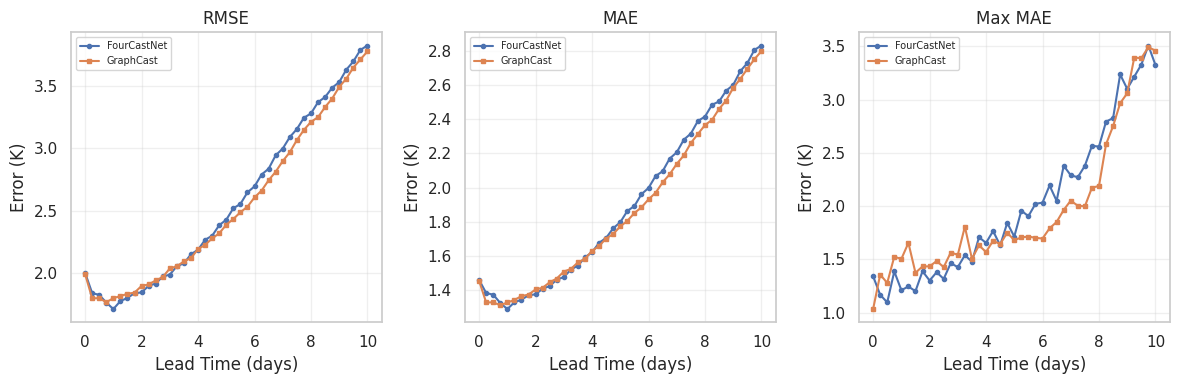

In [60]:
metrics = ['RootMeanSquaredError', 'MeanAbsoluteError', 'MaximumMeanAbsoluteError']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, metric in zip(axes, metrics):
    fc = fourcast_results[(fourcast_results['metric'] == metric) &
                          (fourcast_results['target_source'] == 'ERA5')].copy()
    gc = graphcast_results[(graphcast_results['metric'] == metric) &
                           (graphcast_results['target_source'] == 'ERA5')].copy()

    fc['lead_days'] = pd.to_timedelta(fc['lead_time']).dt.total_seconds() / 86400
    gc['lead_days'] = pd.to_timedelta(gc['lead_time']).dt.total_seconds() / 86400

    fc_mean = fc.groupby('lead_days')['value'].mean()
    gc_mean = gc.groupby('lead_days')['value'].mean()

    ax.plot(fc_mean.index, fc_mean.values, marker='o', label='FourCastNet', markersize=3)
    ax.plot(gc_mean.index, gc_mean.values, marker='s', label='GraphCast', markersize=3)
    ax.set_xlabel('Lead Time (days)')
    ax.set_ylabel('Error (K)')
    ax.set_title(metric.replace('MeanAbsoluteError', 'MAE').replace('RootMeanSquaredError', 'RMSE').replace('Maximum', 'Max '))
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

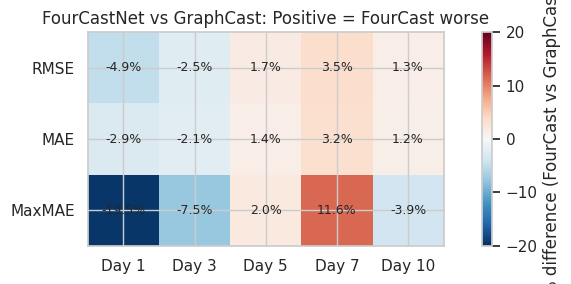

In [59]:
lead_days = [1, 3, 5, 7, 10]

def get_mean_at_leads(df, metric, target, leads):
    subset = df[(df['metric'] == metric) & (df['target_source'] == target)].copy()
    subset['lead_days'] = pd.to_timedelta(subset['lead_time']).dt.total_seconds() / 86400
    return [subset[subset['lead_days'] == d]['value'].mean() for d in leads]

metrics_short = ['RMSE', 'MAE', 'MaxMAE']
metrics_full = ['RootMeanSquaredError', 'MeanAbsoluteError', 'MaximumMeanAbsoluteError']

fc_scores = np.array([get_mean_at_leads(fourcast_results, m, 'ERA5', lead_days) for m in metrics_full])
gc_scores = np.array([get_mean_at_leads(graphcast_results, m, 'ERA5', lead_days) for m in metrics_full])

# Relative difference: (FC - GC) / GC * 100
rel_diff = (fc_scores - gc_scores) / gc_scores * 100

fig, ax = plt.subplots(figsize=(8, 3))
im = ax.imshow(rel_diff, cmap='RdBu_r', vmin=-20, vmax=20)

ax.set_xticks(range(len(lead_days)))
ax.set_xticklabels([f'Day {d}' for d in lead_days])
ax.set_yticks(range(len(metrics_short)))
ax.set_yticklabels(metrics_short)

for i in range(len(metrics_short)):
    for j in range(len(lead_days)):
        ax.text(j, i, f'{rel_diff[i,j]:.1f}%', ha='center', va='center', fontsize=9)

plt.colorbar(im, label='% difference (FourCast vs GraphCast)')
ax.set_title('FourCastNet vs GraphCast: Positive = FourCast worse')
plt.tight_layout()
plt.show()